In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import cartopy.crs as ccrs
import sys
import inversion
import numpy as np
import pandas as pd
import sys
sys.path.append("/cerea_raid/users/dumontj/dev/coco2/dl/ddeq_cosmo/cross_sectional/src")
import ddeq
from ddeq.smartcarb import DOMAIN
import build_ds

<IPython.core.display.Javascript object>

In [5]:
PS = "Lippendorf"

<IPython.core.display.Javascript object>

In [6]:
data = inversion.get_ddeq_predictions_for_PS(PS, selection="random", N_pred=1)
data = data.rename({"xco2": "CO2", "sources": "source", "no2": "NO2", "y": "nobs", "x": "nrows"})

['point_source', 'time', 'xco2', 'no2', 'xco2_noisy', 'no2_noisy', 'emiss', 'plume', 'u', 'v', 'bool_perf_seg', 'v_hour', 'weight_bool_plume', 'xco2_std', 'no2_std', 'lon', 'lat', 'lon_o', 'lat_o', 'type', 'UTF-8', 'radius', 'xco2_local_median', 'z_values', 'is_hit', 'labels', 'local_xco2_mean', 'local_xco2_pixels', 'detected_plume', 'no2_local_median', 'local_no2_mean', 'local_no2_pixels']


<IPython.core.display.Javascript object>

In [7]:
data = data.isel(idx_img=0)
data.CO2.attrs["units"] = "ppm"
data.NO2.attrs["units"] = 'molecules cm-2'
data.attrs["noise"] = 0.7
data.attrs["trace_gas"] = "CO2"
data["type"] = (["source"], ["power plant"]*len(data.source.values))
data["type"] =  data["type"].astype(object)

data["psurf"] = data["xco2_noisy"]
data = ddeq.emissions.prepare_data(data, "CO2")
data = ddeq.emissions.prepare_data(data, 'NO2')
CRS = ccrs.UTM(32)

lonc = 
data["lonc"] = (["

<IPython.core.display.Javascript object>

In [11]:
data

<xarray.Dataset>
Dimensions:                              (nobs: 64, nrows: 64, source: 2,
                                          hour_prec: 3)
Coordinates:
  * nobs                                 (nobs) int32 0 1 2 3 4 ... 60 61 62 63
  * nrows                                (nrows) int32 0 1 2 3 4 ... 60 61 62 63
  * source                               (source) object 'Lippendorf' 'Schkopau'
    idx_img                              int32 518
Dimensions without coordinates: hour_prec
Data variables: (12/44)
    point_source                         object ...
    time                                 datetime64[ns] ...
    CO2                                  (nobs, nrows) float32 405.3 ... 405.3
    NO2                                  (nobs, nrows) float32 2.303e+15 ... ...
    xco2_noisy                           (nobs, nrows) float32 406.7 ... 405.8
    no2_noisy                            (nobs, nrows) float32 3.833e+14 ... ...
    ...                                   ...
    NO2_estimated_background_mass        (nobs, nrows) float64 1.951e-06 ... ...
    NO2_minus_estimated_background_mass  (nobs, nrows) float64 -1.915e-07 ......
    x                                    (nobs, nrows) float64 7.005e+05 ... ...
    y                                    (nobs, nrows) float64 5.64e+06 ... 5...
    x_o                                  (source) float64 7.356e+05 7.052e+05
    y_o                                  (source) float64 5.676e+06 5.698e+06
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_img:        1152
    noise:        0.7
    trace_gas:    CO2

<IPython.core.display.Javascript object>

In [9]:
data, curves = ddeq.plume_coords.compute_plume_line_and_coords(
    data, crs=CRS, radius=25e3, plume_area='area'
)

AttributeError: 'Dataset' object has no attribute 'xc'

<IPython.core.display.Javascript object>

In [44]:
this = ddeq.misc.select_source(data, source=PS)

<IPython.core.display.Javascript object>

In [45]:
def calculate_wind_direction(u, v):
    return (270.0 - np.rad2deg(np.arctan2(v,u))) % 360

<IPython.core.display.Javascript object>

In [46]:
wind_speed = np.sqrt(np.mean(data.u.values)**2 + np.mean(data.v.values)**2)

<IPython.core.display.Javascript object>

In [47]:
wind_direction = calculate_wind_direction(np.mean(data.u.values), np.mean(data.v.values))

<IPython.core.display.Javascript object>

In [48]:
results = ddeq.xs.estimate(
    this, curves[PS], PS, trace_gases=['CO2', "NO2"], 
    wind_speed=float(wind_speed), wind_direction=float(wind_direction),
    method='cs', crs=CRS
)

NotImplementedError: 

<IPython.core.display.Javascript object>

In [19]:

def get_pixels_corners(center_x_arr, center_y_arr):
    """
    Calcule les coordonnées des coins de pixels en fonction des centres et détermine automatiquement la taille des pixels.
    
    Args:
    center_x_arr (np.array): une matrice numpy contenant les coordonnées x des centres des pixels
    center_y_arr (np.array): une matrice numpy contenant les coordonnées y des centres des pixels
    
    Returns:
    corners_arr (np.array): une matrice numpy contenant les coordonnées des coins de chaque pixel. Chaque ligne du tableau 
                            contient les coordonnées des quatre coins du pixel, dans l'ordre suivant : 
                            coin supérieur gauche, coin supérieur droit, coin inférieur droit, coin inférieur gauche
    """
    x_diff = np.diff(center_x_arr, axis=1)
    y_diff = np.diff(center_y_arr, axis=0)
    
    x_size = np.median(x_diff)
    y_size = np.median(y_diff)
    
    half_x_size = x_size / 2.0
    half_y_size = y_size / 2.0
    
    x1 = center_x_arr - half_x_size
    y1 = center_y_arr - half_y_size
    
    x2 = center_x_arr + half_x_size
    y2 = center_y_arr - half_y_size
    
    x3 = center_x_arr + half_x_size
    y3 = center_y_arr + half_y_size
    
    x4 = center_x_arr - half_x_size
    y4 = center_y_arr + half_y_size
    
    corners_arr = np.array([x1, y1, x2, y2, x3, y3, x4, y4])
    corners_arr = corners_arr.transpose((1, 2, 0)).reshape(center_x_arr.shape[0], center_x_arr.shape[1], 8)
    
    return corners_arr

<IPython.core.display.Javascript object>

In [20]:
a = get_pixels_corners(data.lon, data.lat)

<IPython.core.display.Javascript object>

In [26]:
import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>

In [32]:
def plot_pixels(center_x_arr, center_y_arr, corners_arr):
    """
    Trace les centres et les coins des pixels.
    
    Args:
    center_x_arr (np.array): une matrice numpy contenant les coordonnées x des centres des pixels
    center_y_arr (np.array): une matrice numpy contenant les coordonnées y des centres des pixels
    corners_arr (np.array): une matrice numpy contenant les coordonnées des coins de chaque pixel. Chaque ligne du tableau 
                            contient les coordonnées des quatre coins du pixel, dans l'ordre suivant : 
                            coin supérieur gauche, coin supérieur droit, coin inférieur droit, coin inférieur gauche
    """
    fig, ax = plt.subplots()

    # Plot the center points
    ax.plot(center_x_arr, center_y_arr, 'bo', label='Centers')

    # Plot the corners
    for i in range(center_x_arr.shape[0]):
        for j in range(center_x_arr.shape[1]):
            ax.plot(corners_arr[i,j,0::2], corners_arr[i,j,1::2], 'r-', linewidth=2)

    plt.show()

<IPython.core.display.Javascript object>

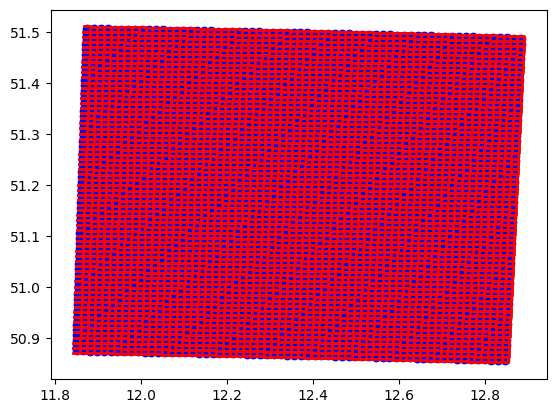

<IPython.core.display.Javascript object>

In [33]:
plot_pixels(data.lon, data.lat, get_pixels_corners(data.lon, data.lat))

In [37]:
center_x_arr = data.lon
center_y_arr = data.lat

<IPython.core.display.Javascript object>

In [34]:
data.lon

<xarray.DataArray 'lon' (nobs: 64, nrows: 64)>
array([[11.85012627, 11.86593246, 11.88173962, ..., 12.81401062,
        12.82980537, 12.84560013],
       [11.85050106, 11.86631107, 11.88212109, ..., 12.81458092,
        12.83037949, 12.8461771 ],
       [11.85087681, 11.86668968, 11.88250256, ..., 12.81515121,
        12.83095264, 12.84675407],
       ...,
       [11.87330914, 11.8893137 , 11.90531826, ..., 12.84924984,
        12.865242  , 12.88123417],
       [11.87369442, 11.88970184, 11.90571022, ..., 12.8498354 ,
        12.86583042, 12.88182545],
       [11.8740797 , 11.89009094, 11.90610218, ..., 12.85042095,
        12.86641979, 12.88241768]])
Coordinates:
  * nobs     (nobs) int32 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62 63
  * nrows    (nrows) int32 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62 63
    idx_img  int32 518

<IPython.core.display.Javascript object>

In [38]:
import numpy as np

def get_pixels_corners(center_x_arr, center_y_arr):
    """
    Calcule les coins des pixels à partir des coordonnées de leurs centres, en tenant compte de la taille variable des pixels.
    
    Args:
    center_x_arr (np.array): une matrice numpy contenant les coordonnées x des centres des pixels
    center_y_arr (np.array): une matrice numpy contenant les coordonnées y des centres des pixels
    
    Returns:
    np.array, np.array : deux tableaux numpy contenant les coordonnées x et y des coins des pixels.
    """
    # Calculer la taille variable des pixels en x et y
    pixel_size_x = np.diff(center_x_arr, axis=1)
    pixel_size_y = np.diff(center_y_arr, axis=0)

    # Ajouter les tailles des bords gauche et supérieur
    pixel_size_x = np.concatenate((pixel_size_x[:,0].reshape(-1,1), pixel_size_x), axis=1)
    pixel_size_y = np.concatenate((pixel_size_y[0,:].reshape(1,-1), pixel_size_y), axis=0)

    # Calculer les coordonnées des coins des pixels
    corners_x = np.stack((center_x_arr - pixel_size_x/2, center_x_arr + pixel_size_x/2,
                          center_x_arr + pixel_size_x/2, center_x_arr - pixel_size_x/2), axis=-1)
    corners_y = np.stack((center_y_arr + pixel_size_y/2, center_y_arr + pixel_size_y/2,
                          center_y_arr - pixel_size_y/2, center_y_arr - pixel_size_y/2), axis=-1)

    # Empiler les coordonnées des coins des pixels en un seul tableau
    corners_arr = np.stack((corners_x, corners_y), axis=-1)

    return corners_x, corners_y

<IPython.core.display.Javascript object>

In [40]:
center_x_arr

<xarray.DataArray 'lon' (nobs: 64, nrows: 64)>
array([[11.85012627, 11.86593246, 11.88173962, ..., 12.81401062,
        12.82980537, 12.84560013],
       [11.85050106, 11.86631107, 11.88212109, ..., 12.81458092,
        12.83037949, 12.8461771 ],
       [11.85087681, 11.86668968, 11.88250256, ..., 12.81515121,
        12.83095264, 12.84675407],
       ...,
       [11.87330914, 11.8893137 , 11.90531826, ..., 12.84924984,
        12.865242  , 12.88123417],
       [11.87369442, 11.88970184, 11.90571022, ..., 12.8498354 ,
        12.86583042, 12.88182545],
       [11.8740797 , 11.89009094, 11.90610218, ..., 12.85042095,
        12.86641979, 12.88241768]])
Coordinates:
  * nobs     (nobs) int32 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62 63
  * nrows    (nrows) int32 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62 63
    idx_img  int32 518

<IPython.core.display.Javascript object>

In [39]:
get_pixels_corners(center_x_arr, center_y_arr)

(array([[[11.84222317, 11.85802937, 11.85802937, 11.84222317],
         [11.85802937, 11.87383556, 11.87383556, 11.85802937],
         [11.87383604, 11.88964319, 11.88964319, 11.87383604],
         ...,
         [12.80611324, 12.821908  , 12.821908  , 12.80611324],
         [12.821908  , 12.83770275, 12.83770275, 12.821908  ],
         [12.83770275, 12.85349751, 12.85349751, 12.83770275]],
 
        [[11.84259605, 11.85840607, 11.85840607, 11.84259605],
         [11.85840607, 11.87421608, 11.87421608, 11.85840607],
         [11.87421608, 11.89002609, 11.89002609, 11.87421608],
         ...,
         [12.80668163, 12.8224802 , 12.8224802 , 12.80668163],
         [12.8224802 , 12.83827877, 12.83827877, 12.8224802 ],
         [12.83827829, 12.85407591, 12.85407591, 12.83827829]],
 
        [[11.84297037, 11.85878325, 11.85878325, 11.84297037],
         [11.85878325, 11.87459612, 11.87459612, 11.85878325],
         [11.87459612, 11.89040899, 11.89040899, 11.87459612],
         ...,
       

<IPython.core.display.Javascript object>

In [45]:
import numpy as np

def get_pixels_corners(lon_arr, lat_arr):
    """
    Calcule les coins des pixels à partir des coordonnées de leurs centres en longitude et latitude.
    
    Args:
    lon_arr (np.array): une matrice numpy contenant les coordonnées de longitude des centres des pixels
    lat_arr (np.array): une matrice numpy contenant les coordonnées de latitude des centres des pixels
    
    Returns:
    np.array, np.array : deux tableaux numpy contenant les coordonnées de longitude et de latitude des coins des pixels.
    """
    # Convertir les coordonnées en latitude et longitude en coordonnées cartésiennes
    R = 6371000.0  # Rayon de la Terre en mètres
    x = R * np.cos(np.radians(lat_arr)) * np.cos(np.radians(lon_arr))[:,:,np.newaxis]
    y = R * np.cos(np.radians(lat_arr)) * np.sin(np.radians(lon_arr))[:,:,np.newaxis]
    z = R * np.sin(np.radians(lat_arr))[:,:,np.newaxis]

    # Calculer les coordonnées des coins des pixels en coordonnées cartésiennes
    pixel_size_x = np.diff(x, axis=1)
    pixel_size_y = np.diff(y, axis=0)
    pixel_size_x = np.concatenate((pixel_size_x[:,0,:][:,np.newaxis,:], pixel_size_x), axis=1)
    pixel_size_y = np.concatenate((pixel_size_y[0,:,:][np.newaxis,:,:], pixel_size_y), axis=0)
    corners_x = np.stack((x - pixel_size_x/2, x + pixel_size_x/2,
                          x + pixel_size_x/2, x - pixel_size_x/2), axis=-1)
    corners_y = np.stack((y + pixel_size_y/2, y + pixel_size_y/2,
                          y - pixel_size_y/2, y - pixel_size_y/2), axis=-1)
    corners_z = np.stack((z, z, z, z), axis=-1)

    # Convertir les coordonnées des coins des pixels en coordonnées en latitude et longitude
    corners_r = np.sqrt(np.sum(corners_x**2 + corners_y**2 + corners_z**2, axis=-1))
    corners_lat = np.degrees(np.arcsin(corners_z / corners_r))
    corners_lon = np.degrees(np.arctan2(corners_y, corners_x))

    return corners_lon, corners_lat


<IPython.core.display.Javascript object>

In [46]:
get_pixels_corners(data.lon, data.lat)

IndexError: too many indices

<IPython.core.display.Javascript object>